# Bahdanau Attention

:label:`sec_seq2seq_attention`

We studied the machine translation
problem in :numref:`sec_seq2seq`,
where we designed
an encoder-decoder architecture based on two RNNs
for sequence to sequence learning.
Specifically,
the RNN encoder
transforms
a variable-length sequence
into a fixed-shape context variable,
then
the RNN decoder
generates the output (target) sequence token by token
based on the generated tokens and the context variable.
However,
even though not all the input (source) tokens
are useful for decoding a certain token,
the *same* context variable
that encodes the entire input sequence
is still used at each decoding step.

In a separate but related
challenge of handwriting generation for a given text sequence,
Graves designed a differentiable attention model
to align text characters with the much longer pen trace,
where the alignment moves only in one direction :cite:`Graves.2013`.
Inspired by the idea of learning to align,
Bahdanau et al. proposed a differentiable attention model
without the severe unidirectional alignment limitation :cite:`Bahdanau.Cho.Bengio.2014`.
When predicting a token,
if not all the input tokens are relevant,
the model aligns (or attends)
only to parts of the input sequence that are relevant to the current prediction.
This is achieved
by treating the context variable as an output of attention pooling.

## Model

When describing
Bahdanau attention
for the RNN encoder-decoder below,
we will follow the same notation in
:numref:`sec_seq2seq`.
The new attention-based model
is the same as that
in :numref:`sec_seq2seq`
except that
the context variable
$\mathbf{c}$
in
:eqref:`eq_seq2seq_s_t`
is replaced by
$\mathbf{c}_{t'}$
at any decoding time step $t'$.
Suppose that
there are $T$ tokens in the input sequence,
the context variable at the decoding time step $t'$
is the output of attention pooling:

$$\mathbf{c}_{t'} = \sum_{t=1}^T \alpha(\mathbf{s}_{t' - 1}, \mathbf{h}_t) \mathbf{h}_t,$$

where the decoder hidden state
$\mathbf{s}_{t' - 1}$ at time step $t' - 1$
is the query,
and the encoder hidden states $\mathbf{h}_t$
are both the keys and values,
and the attention weight $\alpha$
is computed as in
:eqref:`eq_attn-scoring-alpha`
using the additive attention scoring function
defined by
:eqref:`eq_additive-attn`.

Slightly different from
the vanilla RNN encoder-decoder architecture
in :numref:`fig_seq2seq_details`,
the same architecture
with Bahdanau attention is depicted in
:numref:`fig_s2s_attention_details`.

![Layers in an RNN encoder-decoder model with Bahdanau attention.](../img/seq2seq-attention-details.svg)
:label:`fig_s2s_attention_details`


In [1]:
import torch
from torch import nn
from d2l import torch as d2l

## Defining the Decoder with Attention

To implement the RNN encoder-decoder
with Bahdanau attention,
we only need to redefine the decoder.
To visualize the learned attention weights more conveniently,
the following `AttentionDecoder` class
defines [**the base interface for
decoders with attention mechanisms**].


In [2]:
#@save
class AttentionDecoder(d2l.Decoder):
    """The base attention-based decoder interface."""
    def __init__(self, **kwargs):
        super(AttentionDecoder, self).__init__(**kwargs)

    @property
    def attention_weights(self):
        raise NotImplementedError

Now let us [**implement
the RNN decoder with Bahdanau attention**]
in the following `Seq2SeqAttentionDecoder` class.
The state of the decoder
is initialized with

1. the encoder final-layer hidden states at all the time steps (as keys and values of the attention);
1.  the encoder all-layer hidden state at the final time step (to initialize the hidden state of the decoder);
1. the encoder valid length (to exclude the padding tokens in attention pooling).

At each decoding time step,
the decoder final-layer hidden state at the previous time step is used as the query of the attention.
As a result, both the attention output
and the input embedding are concatenated
as the input of the RNN decoder.


In [3]:
class Seq2SeqAttentionDecoder(AttentionDecoder):
    def __init__(self, vocab_size, embed_size, num_hiddens, num_layers,
                 dropout=0, **kwargs):
        super(Seq2SeqAttentionDecoder, self).__init__(**kwargs)
        self.attention = d2l.AdditiveAttention(num_hiddens, num_hiddens,
                                               num_hiddens, dropout)
        self.embedding = nn.Embedding(vocab_size, embed_size)
        self.rnn = nn.GRU(embed_size + num_hiddens, num_hiddens, num_layers,
                          dropout=dropout)
        self.dense = nn.Linear(num_hiddens, vocab_size)

    def init_state(self, enc_outputs, enc_valid_lens, *args):
        # Shape of `outputs`: (`num_steps`, `batch_size`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`,
        # `num_hiddens`)
        outputs, hidden_state = enc_outputs
        return (outputs.permute(1, 0, 2), hidden_state, enc_valid_lens)

    def forward(self, X, state):
        # Shape of `enc_outputs`: (`batch_size`, `num_steps`, `num_hiddens`).
        # Shape of `hidden_state[0]`: (`num_layers`, `batch_size`, `num_hiddens`)
        enc_outputs, hidden_state, enc_valid_lens = state
        # Shape of the output `X`: (`num_steps`, `batch_size`, `embed_size`)
        X = self.embedding(X).permute(1, 0, 2)
        outputs, self._attention_weights = [], []
        for x in X:  # X = { batch1, batch2, batch3, ... batch_{nsteps} }
            # Shape of `query`: (`batch_size`, 1, `num_hiddens`)
            # -1 is for the first index: h[-1] = h[1,:] since it has 2 items
            query = torch.unsqueeze(hidden_state[-1], dim=1)
#             print('q:', query.shape, hidden_state[-1].shape)
            # Shape of `context`: (`batch_size`, 1, `num_hiddens`)
            context = self.attention(query, enc_outputs, enc_outputs, enc_valid_lens)
#             print('c:', context.shape)
            # Concatenate on the feature dimension
            x = torch.cat((context, torch.unsqueeze(x, dim=1)), dim=-1)
            # Reshape `x` as (1, `batch_size`, `embed_size` + `num_hiddens`)
            out, hidden_state = self.rnn(x.permute(1, 0, 2), hidden_state)
            outputs.append(out)
            self._attention_weights.append(self.attention.attention_weights)
        # After fully-connected layer transformation, 
        # shape of `outputs`: (`num_steps`, `batch_size`, `vocab_size`)
        outputs = self.dense(torch.cat(outputs, dim=0))
        return outputs.permute(1, 0, 2), [
            enc_outputs, hidden_state, enc_valid_lens]

    @property
    def attention_weights(self):
        return self._attention_weights

In the following, we [**test the implemented
decoder**] with Bahdanau attention
using a minibatch of 4 sequence inputs
of 7 time steps.


In [4]:
encoder = d2l.Seq2SeqEncoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
encoder.eval()
#
decoder = Seq2SeqAttentionDecoder(vocab_size=10, embed_size=8, num_hiddens=16, num_layers=2)
decoder.eval()
#
X = torch.zeros((4, 7), dtype=torch.long)  # (`batch_size`, `num_steps`)
state = decoder.init_state(encoder(X), None)
output, state = decoder(X, state)
output.shape, len(state), state[0].shape, len(state[1]), state[1][0].shape

(torch.Size([4, 7, 10]), 3, torch.Size([4, 7, 16]), 2, torch.Size([4, 16]))

In [5]:
enx = encoder(X)
X.shape, [a.shape for a in enx]

(torch.Size([4, 7]), [torch.Size([7, 4, 16]), torch.Size([2, 4, 16])])

## [**Training**]

Similar to :numref:`sec_seq2seq_training`,
here we specify hyperparemeters,
instantiate
an encoder and a decoder with Bahdanau attention,
and train this model for machine translation.
Due to the newly added attention mechanism,
this training is much slower than
that in :numref:`sec_seq2seq_training` without attention mechanisms.


In [12]:
print('device:', d2l.try_gpu())

device: cuda:0


loss 0.020, 7146.8 tokens/sec on cuda:0


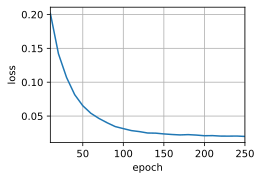

In [6]:
embed_size, num_hiddens, num_layers, dropout = 32, 32, 2, 0.1
batch_size, num_steps = 64, 10
lr, num_epochs, device = 0.005, 250, d2l.try_gpu()

train_iter, src_vocab, tgt_vocab = d2l.load_data_nmt(batch_size, num_steps)
encoder = d2l.Seq2SeqEncoder(len(src_vocab), embed_size, num_hiddens,
                             num_layers, dropout)
decoder = Seq2SeqAttentionDecoder(len(tgt_vocab), embed_size, num_hiddens,
                                  num_layers, dropout)
net = d2l.EncoderDecoder(encoder, decoder)
d2l.train_seq2seq(net, train_iter, lr, num_epochs, tgt_vocab, device)

In [7]:
for data in train_iter:
    print(len(data), [a.shape for a in data])
    break

4 [torch.Size([64, 10]), torch.Size([64]), torch.Size([64, 10]), torch.Size([64])]


In [8]:
src_vocab.idx_to_token[100]

'still'

After the model is trained,
we use it to [**translate a few English sentences**]
into French and compute their BLEU scores.


In [9]:
engs = ['go .', "i lost .", 'he\'s calm .', 'i\'m home .']
fras = ['va !', 'j\'ai perdu .', 'il est calme .', 'je suis chez moi .']
for eng, fra in zip(engs, fras):
    translation, dec_attention_weight_seq = d2l.predict_seq2seq(
        net, eng, src_vocab, tgt_vocab, num_steps, device, True)
    print(f'{eng} => {translation}, ',
          f'bleu {d2l.bleu(translation, fra, k=2):.3f}')

len(src_tokens):  3
go . => va !,  bleu 1.000
len(src_tokens):  4
i lost . => j'ai perdu .,  bleu 1.000
len(src_tokens):  4
he's calm . => il est malade .,  bleu 0.658
len(src_tokens):  4
i'm home . => je suis chez moi .,  bleu 1.000


In [10]:
attention_weights = torch.cat(
    [step[0][0][0] for step in dec_attention_weight_seq], 0).reshape(
        (1, 1, -1, num_steps))

By [**visualizing the attention weights**]
when translating the last English sentence,
we can see that each query assigns non-uniform weights
over key-value pairs.
It shows that at each decoding step,
different parts of the input sequences
are selectively aggregated in the attention pooling.


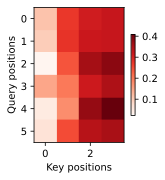

In [11]:
# Plus one to include the end-of-sequence token
d2l.show_heatmaps(
    attention_weights[:, :, :, :len(engs[-1].split()) + 1].cpu(),
    xlabel='Key positions', ylabel='Query positions')

## Summary

* When predicting a token, if not all the input tokens are relevant, the RNN encoder-decoder with Bahdanau attention selectively aggregates different parts of the input sequence. This is achieved by treating the context variable as an output of additive attention pooling.
* In the RNN encoder-decoder, Bahdanau attention treats the decoder hidden state at the previous time step as the query, and the encoder hidden states at all the time steps as both the keys and values.

## Exercises

1. Replace GRU with LSTM in the experiment.
1. Modify the experiment to replace the additive attention scoring function with the scaled dot-product. How does it influence the training efficiency?


[Discussions](https://discuss.d2l.ai/t/1065)
